In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tempfile
import tensorflow_model_optimization as tfmot
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras import backend as K
from tensorflow.keras.models import save_model, load_model
#from tensorflow.keras.callbacks import Callback
#%load_ext tensorboard
%matplotlib widget
from mine import MINE
%run functions.ipynb

In [2]:
# Load the MNIST dataset using TensorFlow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Display the shapes of the training and test datasets
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

# reshape data as 2D numpy arrays
# convert to float32 and normalize grayscale for better num. representation
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# The tutorial reserved 10.000 training samples for validation, we change to 5.000 
# as that is what Frankle and Carbin did in their paper
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

Training data shape: (60000, 28, 28) (60000,)
Test data shape: (10000, 28, 28) (10000,)


In [3]:
# Hyperparams
batch_size = 60 # batchsize, 60 images per weight update
epochs = 10 # nr. of epochs we train our models

input_dim = 784 # input_distribution size for MINE
d1_dim = 100 # first hidden layer distribution size for MINE
d2_dim = 100  # second hidden layer distribution size for MINE
output_dim = 10 # output_distribution dim for MINE

validation_split = 1/11 # 5000 val 55000 train data
num_images = x_train.shape[0] * (1 - validation_split) # needed later for tfmot.sparsity
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs # end_step for PolynomialDecay function

pruning_iterations = 13 # Nr. of distinct sparsity levels in LTH notebook
pruning_rate = 0.2 # the pruning rate for LTH, still needed for calculating total sparsity during iteration i 
averaging_iterations = 10

In [4]:
tf.keras.backend.clear_session() # clearing backend right at start, just in case

inputs = keras.Input(shape=(input_dim,), name="digits") # Functional build of a 2-hidden layer fully connected MLP
x = layers.Dense(d1_dim, activation="relu", name="dense_1")(inputs) # methods made no mention of the activaton function specifically
x = layers.Dense(d2_dim, activation="relu", name="dense_2")(x) # ReLU is standard, as all available implementations seem to use it too
outputs = layers.Dense(output_dim, activation="softmax", name="predictions")(x)  # softmax activation for multi-class classification

base_model = keras.Model(inputs=inputs, outputs=outputs)
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 predictions (Dense)         (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [5]:
base_model.load_weights('init_weights.h5') # using same init. weights as other notebook


# Append the data lists to the dictionary for each iteration
data_dict_unstructured = {"accuracies": [],
                          "losses": [],
                          "MI_estimate_x_d1": [],
                          "MI_estimate_x_d2": [],
                          "MI_estimate_d1_d2": [],
                          "MI_hist_x_d1": [],
                          "MI_hist_x_d2": [],
                          "MI_hist_d1_d2": []
                          }

# We do 10 runs to get an average

for j in range(averaging_iterations):
    print("------------------------")
    print("------------------------")
    print("------------------------")
    print("Experimental run number: " + str(j+1))
    print("------------------------")
    print("------------------------")
    print("------------------------")
    # collected outputs for evaluation
    accuracies = []
    losses = []
    MI_estimate_x_d1 = []
    MI_estimate_x_d2 = []
    MI_estimate_d1_d2 = []
    MI_hist_x_d1 = []
    MI_hist_x_d2 = []
    MI_hist_d1_d2 = []

    # compiling model with training params
    model = keras.models.clone_model(base_model)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1.2e-3), # Adam optimizer, lr=0.0012
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(), # multi-class classification loss function
                  # List of metrics to monitor
                  metrics=[keras.metrics.SparseCategoricalAccuracy()],
                 )

    print("")
    print("")
    pre_train_loss, pre_train_accuracy = model.evaluate(x_test, y_test)
    accuracies.append(pre_train_accuracy)
    print("acc appended")
    losses.append(pre_train_loss)
    print("loss appended")
    print("")
    print("")
    print("attempting mutual information neural estimation")
    fit_loss_history_x_d1, mutual_info_x_d1 = get_mine_x_d1(model)
    fit_loss_history_x_d2, mutual_info_x_d2 = get_mine_x_d2(model)
    fit_loss_history_d1_d2, mutual_info_d1_d2 = get_mine_d1_d2(model)
    print("estimated mutual information x_d1: " + str(mutual_info_x_d1))
    print("estimated mutual information x_d2: " + str(mutual_info_x_d2))
    print("estimated mutual information d1_d2: " + str(mutual_info_d1_d2))
    MI_estimate_x_d1.append(mutual_info_x_d1)
    MI_estimate_x_d2.append(mutual_info_x_d2)
    MI_estimate_d1_d2.append(mutual_info_d1_d2)
    print("mutual info appended")
    MI_hist_x_d1.append(fit_loss_history_x_d1)
    MI_hist_x_d2.append(fit_loss_history_x_d2)
    MI_hist_d1_d2.append(fit_loss_history_d1_d2)
    print("fit_loss_history appended")
    print("")
    print("")
    print("fully connected model, pre-train: " + "loss: " + str(pre_train_loss) + " acc: " + str(pre_train_accuracy))
    print("")
    print("")
    print("sanity check")
    print("output layer weight mask, pre-train, first 10 arr: ")
    print((model.layers[3].get_weights()[0][:10] != 0)*1.0)

    # load pre-trained model
    model.load_weights("trained_weights.h5")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1.2e-3), # Adam optimizer, lr=0.0012
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(), # multi-class classification loss function
                  # List of metrics to monitor
                  metrics=[keras.metrics.SparseCategoricalAccuracy()],
                 )
    print("")
    print("")
    trained_loss, trained_accuracy = model.evaluate(x_test, y_test)
    print("fully connected model, trained: " + "loss: " + str(trained_loss) + " acc: " + str(trained_accuracy))
    print("")
    print("")
    accuracies.append(trained_accuracy)
    print("acc appended")
    losses.append(trained_loss)
    print("loss appended")
    print("")
    print("")
    print("attempting mutual information neural estimation")
    fit_loss_history_x_d1, mutual_info_x_d1 = get_mine_x_d1(model)
    fit_loss_history_x_d2, mutual_info_x_d2 = get_mine_x_d2(model)
    fit_loss_history_d1_d2, mutual_info_d1_d2 = get_mine_d1_d2(model)
    print("estimated mutual information x_d1: " + str(mutual_info_x_d1))
    print("estimated mutual information x_d2: " + str(mutual_info_x_d2))
    print("estimated mutual information d1_d2: " + str(mutual_info_d1_d2))
    MI_estimate_x_d1.append(mutual_info_x_d1)
    MI_estimate_x_d2.append(mutual_info_x_d2)
    MI_estimate_d1_d2.append(mutual_info_d1_d2)
    print("mutual info appended")
    MI_hist_x_d1.append(fit_loss_history_x_d1)
    MI_hist_x_d2.append(fit_loss_history_x_d2)
    MI_hist_d1_d2.append(fit_loss_history_d1_d2)
    print("fit_loss_history appended")
    print("")
    print("")
    print("sanity check")
    print("output layer weight mask, trained, fully connected model, first 10 arr: ")
    print((model.layers[3].get_weights()[0][:10] != 0)*1.0)
    trained_model = keras.models.clone_model(model)

    for i in range(pruning_iterations):
        sparsity = calc_sparsity(i,pruning_rate) 
        k = sparsity/100
        # unstructured pruning set-up
        prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

        pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                                                   final_sparsity=k,
                                                                                   begin_step=0,
                                                                                   end_step=end_step)
                         }

        # keras cloning function adapted from tensorflow pruning comprehensive guide
        def apply_pruning(layer):
            if layer.name == 'dense_1':
                return prune_low_magnitude(layer, **pruning_params)
            elif layer.name == 'dense_2':
                return prune_low_magnitude(layer, **pruning_params)
            elif layer.name == 'predictions':
                return prune_low_magnitude(layer, **pruning_params)
            else:
                return layer
            return layer
        
        # build a model with pruning wrappers using custom cloning function on trained baseline model
        model = keras.models.clone_model(trained_model, clone_function=apply_pruning)

        # recompiling pruned model with training params
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1.2e-3), # Adam optimizer, lr=0.0012
            # Loss function to minimize
            loss=keras.losses.SparseCategoricalCrossentropy(), # multi-class classification loss function
            # List of metrics to monitor
            metrics=[keras.metrics.SparseCategoricalAccuracy()],
        )
        callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),
                    ]
        print(f"Iteration {i+1}: making {sparsity:.2f}% sparse unstructured Network")
        history = model.fit(x_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            # monitoring validation loss and metrics
                            # at the end of each epoch
                            validation_data=(x_val, y_val),
                            callbacks=callbacks
                           )

        print("")
        print("")
        loss, accuracy = model.evaluate(x_test, y_test)
        print(f"{sparsity:.2f}% sparse unstructured model: " + "loss: " + str(loss) + " acc: " + str(accuracy))
        print("")
        print("")
        accuracies.append(accuracy)
        print("acc appended")
        losses.append(loss)
        print("loss appended")
        print("")
        print("")
        print("attempting mutual information neural estimation")
        fit_loss_history_x_d1, mutual_info_x_d1 = get_mine_x_d1(model)
        fit_loss_history_x_d2, mutual_info_x_d2 = get_mine_x_d2(model)
        fit_loss_history_d1_d2, mutual_info_d1_d2 = get_mine_d1_d2(model)
        print("estimated mutual information x_d1: " + str(mutual_info_x_d1))
        print("estimated mutual information x_d2: " + str(mutual_info_x_d2))
        print("estimated mutual information d1_d2: " + str(mutual_info_d1_d2))
        MI_estimate_x_d1.append(mutual_info_x_d1)
        MI_estimate_x_d2.append(mutual_info_x_d2)
        MI_estimate_d1_d2.append(mutual_info_d1_d2)
        print("mutual info appended")
        MI_hist_x_d1.append(fit_loss_history_x_d1)
        MI_hist_x_d2.append(fit_loss_history_x_d2)
        MI_hist_d1_d2.append(fit_loss_history_d1_d2)
        print("fit_loss_history appended")
        print("")
        print("")
        print("sanity check")
        print(f"output layer weight mask, {sparsity:.2f}% sparse unstructured model, first 10 arr: ")
        print((model.layers[3].get_weights()[0][:10] != 0)*1.0)

    # saving data for averaging     
    data_dict_unstructured["accuracies"].append(accuracies)
    data_dict_unstructured["losses"].append(losses)
    data_dict_unstructured["MI_estimate_x_d1"].append(MI_estimate_x_d1)
    data_dict_unstructured["MI_estimate_x_d2"].append(MI_estimate_x_d2)
    data_dict_unstructured["MI_estimate_d1_d2"].append(MI_estimate_d1_d2)
    data_dict_unstructured["MI_hist_x_d1"].append(MI_hist_x_d1)
    data_dict_unstructured["MI_hist_x_d2"].append(MI_hist_x_d2)
    data_dict_unstructured["MI_hist_d1_d2"].append(MI_hist_d1_d2)
    print(f"Experiment {j+1} saved in Dictionary")

------------------------
------------------------
------------------------
Experimental run number: 1
------------------------
------------------------
------------------------


313/313 [==============================] - 0s 744us/step - loss: 2.3643 - sparse_categorical_accuracy: 0.0957
acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 1s - loss: -1.0916e+00 - 1s/epoch - 2ms/step
Epoch 2/5
550/550 - 1s - loss: -2.1956e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5081e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.7424e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8903e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 1s - loss: -8.7937e-01 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.9170e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.1452e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.3183e+00 - 1s/epoch - 2



313/313 [==============================] - 0s 900us/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9817
48.80% sparse unstructured model: loss: 0.11582006514072418 acc: 0.9817000031471252


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 1s - loss: -1.1195e+00 - 1s/epoch - 2ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2503e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.4961e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.7577e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.9158e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 6s 3ms/step
Epoch 1/5
550/550 - 2s - loss: -5.8837e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.4637e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.8395e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.0475e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2122e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 856us/step - loss: 0.1190 - sparse_categorical_accuracy: 0.9799
79.03% sparse unstructured model: loss: 0.11897719651460648 acc: 0.9799000024795532


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 1s - loss: -1.1941e+00 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.3743e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.6164e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.7805e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.9844e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 1s - loss: -7.3664e-01 - 1s/epoch - 2ms/step
Epoch 2/5
550/550 - 1s - loss: -1.7004e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9940e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.2114e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3552e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 850us/step - loss: 0.1341 - sparse_categorical_accuracy: 0.9709
91.41% sparse unstructured model: loss: 0.1340792030096054 acc: 0.9708999991416931


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0754e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2453e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.4857e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.6625e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.9176e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 1s - loss: -6.8933e-01 - 1s/epoch - 2ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6526e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9605e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1344e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2216e+00 - 1s/epoch - 2ms/step
1719/1719 [========

313/313 [==============================] - 0s 875us/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9730
fully connected model, trained: loss: 0.09776930510997772 acc: 0.9729999899864197


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 1s - loss: -1.1164e+00 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.1928e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5393e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.6939e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.9319e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 7s 4ms/step
Epoch 1/5
550/550 - 1s - loss: -7.0090e-01 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6020e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9284e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1383e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3138e+00 - 1s/epoch - 2ms/step
1719/1719 [===========



313/313 [==============================] - 0s 856us/step - loss: 0.1284 - sparse_categorical_accuracy: 0.9826
59.04% sparse unstructured model: loss: 0.12837179005146027 acc: 0.9825999736785889


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 1s - loss: -1.1507e+00 - 1s/epoch - 2ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2618e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5342e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.7216e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8809e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 6s 3ms/step
Epoch 1/5
550/550 - 1s - loss: -7.0769e-01 - 1s/epoch - 2ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6363e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9188e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1222e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3136e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 850us/step - loss: 0.1112 - sparse_categorical_accuracy: 0.9797
83.22% sparse unstructured model: loss: 0.111171655356884 acc: 0.9797000288963318


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1844e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.3013e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.6115e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.8005e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.9520e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 1s - loss: -7.7612e-01 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.7601e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9857e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.2319e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3823e+00 - 1s/epoch - 2ms/step
1719/1719 [=========



313/313 [==============================] - 0s 850us/step - loss: 0.1419 - sparse_categorical_accuracy: 0.9649
93.13% sparse unstructured model: loss: 0.14187809824943542 acc: 0.964900016784668


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 1s - loss: -1.1695e+00 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2805e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5957e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.7601e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.9130e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 1s - loss: -7.2852e-01 - 1s/epoch - 2ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6803e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9837e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1679e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2712e+00 - 1s/epoch - 2ms/step
1719/1719 [========



313/313 [==============================] - 0s 855us/step - loss: 0.0901 - sparse_categorical_accuracy: 0.9771
20.00% sparse unstructured model: loss: 0.0901430994272232 acc: 0.9771000146865845


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 1s - loss: -1.1852e+00 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.3463e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.6750e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.8247e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.9771e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 1s - loss: -7.4485e-01 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.7249e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.0515e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.2951e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3682e+00 - 1s/epoch - 2ms/step
1719/1719 [========



313/313 [==============================] - 0s 874us/step - loss: 0.1214 - sparse_categorical_accuracy: 0.9800
67.23% sparse unstructured model: loss: 0.12144603580236435 acc: 0.9800000190734863


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1273e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2338e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5441e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.7501e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8720e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 1s - loss: -7.3689e-01 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6752e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9748e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1214e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2990e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 850us/step - loss: 0.1191 - sparse_categorical_accuracy: 0.9759
86.58% sparse unstructured model: loss: 0.11906567215919495 acc: 0.9758999943733215


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 1s - loss: -1.1210e+00 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.3310e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.6281e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.8053e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8983e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 4s 2ms/step
Epoch 1/5
550/550 - 1s - loss: -7.5651e-01 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.7239e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.0268e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1914e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3962e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 836us/step - loss: 0.1589 - sparse_categorical_accuracy: 0.9577
94.50% sparse unstructured model: loss: 0.15887609124183655 acc: 0.9577000141143799


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0677e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2264e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5363e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.6409e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8303e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 4s 2ms/step
Epoch 1/5
550/550 - 1s - loss: -6.0423e-01 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.4620e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.8854e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1706e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2999e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 837us/step - loss: 0.1179 - sparse_categorical_accuracy: 0.9772
36.00% sparse unstructured model: loss: 0.11788500845432281 acc: 0.9771999716758728


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0859e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.1863e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.4829e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.7163e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8002e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 1s - loss: -6.3170e-01 - 1s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.5149e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9499e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.2296e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3129e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 833us/step - loss: 0.1155 - sparse_categorical_accuracy: 0.9805
73.79% sparse unstructured model: loss: 0.11554128676652908 acc: 0.9804999828338623


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -9.7620e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.1738e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5036e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.7672e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8899e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -6.0976e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.4875e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.8363e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.0320e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2325e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 836us/step - loss: 0.1189 - sparse_categorical_accuracy: 0.9748
89.26% sparse unstructured model: loss: 0.11891517043113708 acc: 0.9747999906539917


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1775e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.3347e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5413e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.6978e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.9116e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -7.3465e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6980e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.0247e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.2159e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2827e+00 - 1s/epoch - 2ms/step
1719/1719 [=======

313/313 [==============================] - 0s 750us/step - loss: 2.2827 - sparse_categorical_accuracy: 0.0967
acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0536e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2122e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.4823e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.6976e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8524e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 4s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -7.0111e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.7105e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.0270e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1671e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3593e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 4s 2ms/step
Epoch 1/5
550/550 - 1s - loss: -3.1777e-01 - 1s/e



313/313 [==============================] - 0s 843us/step - loss: 0.1298 - sparse_categorical_accuracy: 0.9785
48.80% sparse unstructured model: loss: 0.12982209026813507 acc: 0.9785000085830688


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0014e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.0826e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.4771e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.5920e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.7886e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 7s 4ms/step
Epoch 1/5
550/550 - 2s - loss: -6.8133e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6098e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9863e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.0962e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2777e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 840us/step - loss: 0.1203 - sparse_categorical_accuracy: 0.9792
79.03% sparse unstructured model: loss: 0.12028419226408005 acc: 0.979200005531311


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -9.7367e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.0935e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.4749e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.6670e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8611e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 4s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -7.1968e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6269e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9335e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1322e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2734e+00 - 1s/epoch - 2ms/step
1719/1719 [========



313/313 [==============================] - 0s 840us/step - loss: 0.1293 - sparse_categorical_accuracy: 0.9706
91.41% sparse unstructured model: loss: 0.12929709255695343 acc: 0.9706000089645386


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1225e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2857e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5593e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.6965e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.7454e+00 - 1s/epoch - 2ms/step
1719/1719 [==============================] - 4s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -7.9236e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6844e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9889e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1889e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3443e+00 - 1s/epoch - 2ms/step
1719/1719 [=======

313/313 [==============================] - 0s 743us/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9730
fully connected model, trained: loss: 0.09776930510997772 acc: 0.9729999899864197


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0277e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2059e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5376e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.8420e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8761e+00 - 1s/epoch - 3ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -9.7357e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.0275e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.2869e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.4748e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.6353e+00 - 1s/epoch - 2ms/step
1719/1719 [===========



313/313 [==============================] - 0s 840us/step - loss: 0.1300 - sparse_categorical_accuracy: 0.9810
59.04% sparse unstructured model: loss: 0.13001666963100433 acc: 0.9810000061988831


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -9.5073e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.1076e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -2.5057e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.6905e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8878e+00 - 1s/epoch - 3ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -6.9223e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6198e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9103e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1122e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2566e+00 - 1s/epoch - 3ms/step
1719/1719 [=======



313/313 [==============================] - 0s 830us/step - loss: 0.1222 - sparse_categorical_accuracy: 0.9777
83.22% sparse unstructured model: loss: 0.12217771261930466 acc: 0.9776999950408936


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.2588e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.4653e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -2.7189e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.8732e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.9529e+00 - 1s/epoch - 3ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 2s - loss: -7.6389e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.7234e+00 - 1s/epoch - 2ms/step
Epoch 3/5
550/550 - 1s - loss: -2.0250e+00 - 1s/epoch - 2ms/step
Epoch 4/5
550/550 - 1s - loss: -2.2230e+00 - 1s/epoch - 2ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3326e+00 - 1s/epoch - 2ms/step
1719/1719 [=======



313/313 [==============================] - 0s 840us/step - loss: 0.1205 - sparse_categorical_accuracy: 0.9685
93.13% sparse unstructured model: loss: 0.12054414302110672 acc: 0.968500018119812


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0661e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2004e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -2.4093e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.5919e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.7456e+00 - 1s/epoch - 3ms/step
1719/1719 [==============================] - 4s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -8.1297e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.8239e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -2.0174e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1975e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3866e+00 - 1s/epoch - 3ms/step
1719/1719 [========



313/313 [==============================] - 0s 843us/step - loss: 0.0981 - sparse_categorical_accuracy: 0.9750
20.00% sparse unstructured model: loss: 0.09809296578168869 acc: 0.9750000238418579


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0366e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.1796e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -2.4571e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.6803e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.7376e+00 - 1s/epoch - 3ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -6.7176e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6040e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -1.9929e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.1824e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3339e+00 - 1s/epoch - 3ms/step
1719/1719 [=======



313/313 [==============================] - 0s 842us/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9817
67.23% sparse unstructured model: loss: 0.1159587875008583 acc: 0.9817000031471252


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1117e+00 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 1s - loss: -2.2035e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -2.6124e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.8018e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.8668e+00 - 1s/epoch - 3ms/step
1719/1719 [==============================] - 4s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -5.9750e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.4322e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -1.7888e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.0116e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.2029e+00 - 1s/epoch - 3ms/step
1719/1719 [========



313/313 [==============================] - 0s 842us/step - loss: 0.1125 - sparse_categorical_accuracy: 0.9775
86.58% sparse unstructured model: loss: 0.11248490959405899 acc: 0.9775000214576721


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1786e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -2.3478e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -2.6919e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.9294e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -3.0034e+00 - 1s/epoch - 3ms/step
1719/1719 [==============================] - 3s 1ms/step
Epoch 1/5
550/550 - 2s - loss: -7.2652e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 1s - loss: -1.6817e+00 - 1s/epoch - 3ms/step
Epoch 3/5
550/550 - 1s - loss: -2.0063e+00 - 1s/epoch - 3ms/step
Epoch 4/5
550/550 - 1s - loss: -2.2022e+00 - 1s/epoch - 3ms/step
Epoch 5/5
550/550 - 1s - loss: -2.3525e+00 - 1s/epoch - 3ms/step
1719/1719 [=======



313/313 [==============================] - 0s 845us/step - loss: 0.1580 - sparse_categorical_accuracy: 0.9560
94.50% sparse unstructured model: loss: 0.157964825630188 acc: 0.9559999704360962


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.2037e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 2s - loss: -2.3421e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -2.5873e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.8349e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.9907e+00 - 2s/epoch - 3ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -6.6172e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 2s - loss: -1.4979e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -1.8465e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.0179e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.2406e+00 - 2s/epoch - 3ms/step
1719/1719 [=========



313/313 [==============================] - 0s 836us/step - loss: 0.1280 - sparse_categorical_accuracy: 0.9776
36.00% sparse unstructured model: loss: 0.1280253827571869 acc: 0.9775999784469604


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0845e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 2s - loss: -2.2544e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -2.4470e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.7228e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.8793e+00 - 2s/epoch - 3ms/step
1719/1719 [==============================] - 3s 1ms/step
Epoch 1/5
550/550 - 2s - loss: -6.0969e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 2s - loss: -1.4934e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -1.9458e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.2181e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.4391e+00 - 2s/epoch - 3ms/step
1719/1719 [========



313/313 [==============================] - 0s 834us/step - loss: 0.1109 - sparse_categorical_accuracy: 0.9808
73.79% sparse unstructured model: loss: 0.11087122559547424 acc: 0.9807999730110168


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1458e+00 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 2s - loss: -2.3250e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -2.5790e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.8073e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.9412e+00 - 2s/epoch - 3ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -7.1056e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 2s - loss: -1.6944e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -2.0170e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.1269e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.3396e+00 - 2s/epoch - 3ms/step
1719/1719 [=======



313/313 [==============================] - 0s 845us/step - loss: 0.1251 - sparse_categorical_accuracy: 0.9734
89.26% sparse unstructured model: loss: 0.12506572902202606 acc: 0.9733999967575073


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -9.9672e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 2s - loss: -2.1477e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -2.5106e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.7166e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.8338e+00 - 2s/epoch - 3ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -7.0830e-01 - 2s/epoch - 3ms/step
Epoch 2/5
550/550 - 2s - loss: -1.5940e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -1.9151e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.0348e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.1700e+00 - 2s/epoch - 3ms/step
1719/1719 [=======

313/313 [==============================] - 0s 808us/step - loss: 2.3541 - sparse_categorical_accuracy: 0.0793
acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0941e+00 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -2.3498e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -2.5595e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.7786e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.8636e+00 - 2s/epoch - 3ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -6.5792e-01 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -1.5033e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -1.7481e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -1.9175e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -1.9953e+00 - 2s/epoch - 3ms/step
1719/1719 [==============================] - 3s 2ms/step
Epoch 1/5
550/550 - 1s - loss: -3.5176e-01 - 1s/e



313/313 [==============================] - 0s 885us/step - loss: 0.1387 - sparse_categorical_accuracy: 0.9777
48.80% sparse unstructured model: loss: 0.1386614292860031 acc: 0.9776999950408936


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0840e+00 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -2.3009e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -2.6274e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.8200e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.8352e+00 - 2s/epoch - 3ms/step
1719/1719 [==============================] - 6s 3ms/step
Epoch 1/5
550/550 - 2s - loss: -6.2934e-01 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -1.4790e+00 - 2s/epoch - 3ms/step
Epoch 3/5
550/550 - 2s - loss: -1.8925e+00 - 2s/epoch - 3ms/step
Epoch 4/5
550/550 - 2s - loss: -2.0558e+00 - 2s/epoch - 3ms/step
Epoch 5/5
550/550 - 2s - loss: -2.2717e+00 - 2s/epoch - 3ms/step
1719/1719 [========



313/313 [==============================] - 0s 1ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.9775
79.03% sparse unstructured model: loss: 0.12745127081871033 acc: 0.9775000214576721


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1263e+00 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -2.2137e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -2.4965e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.6859e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.8801e+00 - 2s/epoch - 4ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 2s - loss: -7.4246e-01 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -1.6919e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -1.9578e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.0822e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.2461e+00 - 2s/epoch - 4ms/step
1719/1719 [=========



313/313 [==============================] - 0s 949us/step - loss: 0.1254 - sparse_categorical_accuracy: 0.9731
91.41% sparse unstructured model: loss: 0.12542612850666046 acc: 0.9731000065803528


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0909e+00 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -2.1634e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -2.4916e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.6811e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.8218e+00 - 2s/epoch - 4ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 2s - loss: -7.8977e-01 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -1.7637e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -2.0685e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.2716e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.4318e+00 - 2s/epoch - 4ms/step
1719/1719 [=======

313/313 [==============================] - 0s 920us/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9730
fully connected model, trained: loss: 0.09776930510997772 acc: 0.9729999899864197


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.0627e+00 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -2.1807e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -2.4315e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.7777e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.8301e+00 - 2s/epoch - 4ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 2s - loss: -7.2025e-01 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -1.6656e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -1.9509e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.0796e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.2387e+00 - 2s/epoch - 4ms/step
1719/1719 [===========



313/313 [==============================] - 0s 952us/step - loss: 0.1192 - sparse_categorical_accuracy: 0.9819
59.04% sparse unstructured model: loss: 0.11917977035045624 acc: 0.9818999767303467


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1731e+00 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -2.3167e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -2.5869e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.8328e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.8257e+00 - 2s/epoch - 4ms/step
1719/1719 [==============================] - 4s 2ms/step
Epoch 1/5
550/550 - 2s - loss: -7.4895e-01 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -1.7501e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -1.9656e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.1468e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.1893e+00 - 2s/epoch - 4ms/step
1719/1719 [=======



313/313 [==============================] - 0s 984us/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9807
83.22% sparse unstructured model: loss: 0.10692434012889862 acc: 0.9807000160217285


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 2s - loss: -1.1033e+00 - 2s/epoch - 4ms/step
Epoch 2/5
550/550 - 2s - loss: -2.2220e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -2.5869e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.7935e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.9702e+00 - 2s/epoch - 4ms/step
1719/1719 [==============================] - 6s 3ms/step
Epoch 1/5
550/550 - 3s - loss: -7.2976e-01 - 3s/epoch - 5ms/step
Epoch 2/5
550/550 - 2s - loss: -1.6585e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -1.9746e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.1111e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.2712e+00 - 2s/epoch - 4ms/step
1719/1719 [=======



313/313 [==============================] - 0s 1ms/step - loss: 0.1157 - sparse_categorical_accuracy: 0.9704
93.13% sparse unstructured model: loss: 0.11566513776779175 acc: 0.9703999757766724


acc appended
loss appended


attempting mutual information neural estimation
Epoch 1/5
550/550 - 3s - loss: -1.0196e+00 - 3s/epoch - 5ms/step
Epoch 2/5
550/550 - 2s - loss: -2.1684e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -2.5074e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 2s - loss: -2.7207e+00 - 2s/epoch - 4ms/step
Epoch 5/5
550/550 - 2s - loss: -2.8635e+00 - 2s/epoch - 4ms/step
1719/1719 [==============================] - 5s 3ms/step
Epoch 1/5
550/550 - 3s - loss: -5.8321e-01 - 3s/epoch - 5ms/step
Epoch 2/5
550/550 - 2s - loss: -1.4834e+00 - 2s/epoch - 4ms/step
Epoch 3/5
550/550 - 2s - loss: -1.8337e+00 - 2s/epoch - 4ms/step
Epoch 4/5
550/550 - 3s - loss: -2.0255e+00 - 3s/epoch - 5ms/step
Epoch 5/5
550/550 - 2s - loss: -2.2228e+00 - 2s/epoch - 4ms/step
1719/1719 [=========

In [6]:
custom_ticks = [i for i in range(pruning_iterations+2)] # custom ticks for averaged graphs
custom_labels = ['NT', 'FT'] + [f"{round(calc_sparsity(i, pruning_rate), 2)}%" for i in range(pruning_iterations)] # see above

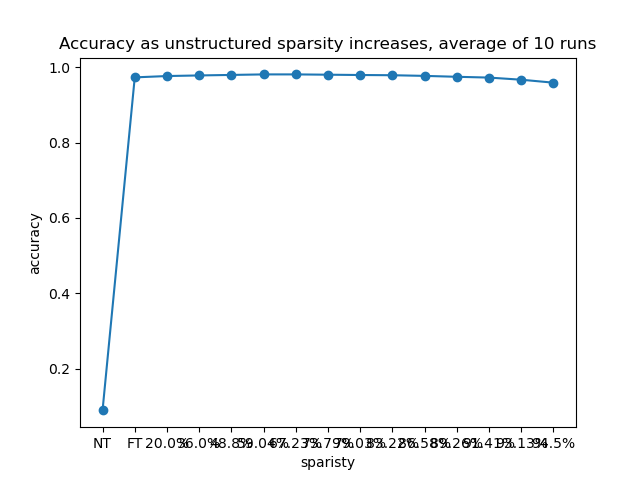

In [7]:
plt.figure(1)
plt.plot(np.average(data_dict_unstructured["accuracies"], axis=0), 'o-')

plt.xticks(custom_ticks,custom_labels)
plt.xlabel('sparisty')
plt.ylabel('accuracy')
plt.title(f'Accuracy as unstructured sparsity increases, average of {averaging_iterations} runs')

# Display the plot
plt.show()

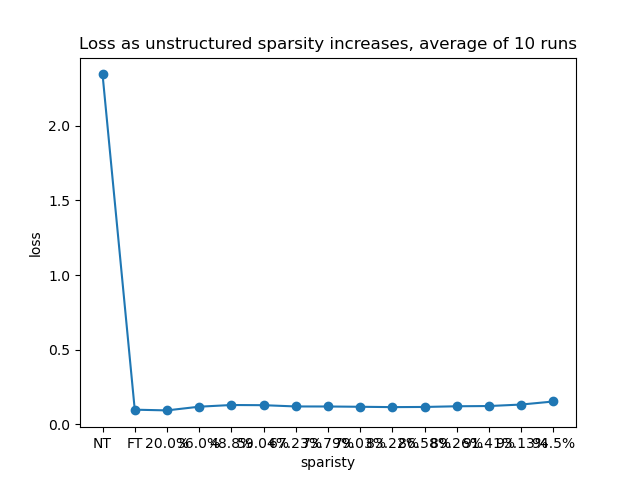

In [8]:
plt.figure(2)
plt.plot(np.average(data_dict_unstructured["losses"], axis=0), 'o-')

plt.xticks(custom_ticks,custom_labels)
plt.xlabel('sparisty')
plt.ylabel('loss')
plt.title(f'Loss as unstructured sparsity increases, average of {averaging_iterations} runs')

# Display the plot
plt.show()

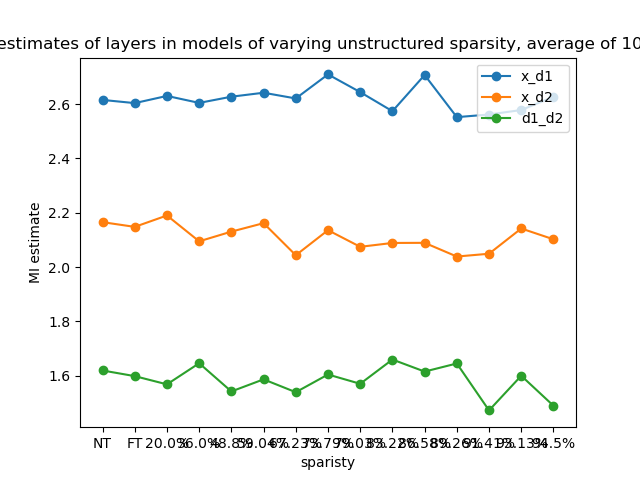

In [9]:
plt.figure(3)
plt.plot(np.average(data_dict_unstructured["MI_estimate_x_d1"], axis=0), 'o-', label="x_d1")
plt.plot(np.average(data_dict_unstructured["MI_estimate_x_d2"], axis=0), 'o-', label="x_d2")
plt.plot(np.average(data_dict_unstructured["MI_estimate_d1_d2"]), axis=0 'o-', label="d1_d2")
plt.legend()
plt.xticks(custom_ticks,custom_labels)
plt.xlabel('sparisty')
plt.ylabel('MI estimate')
plt.title(f'MI estimates of layers in models of varying unstructured sparsity, average of {averaging_iterations} runs')

# Display the plot
plt.show()

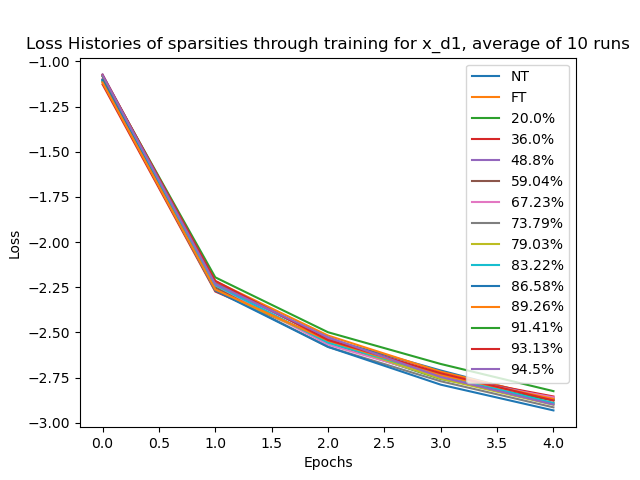

In [10]:
plt.figure(4)
# Plot each loss history with a different label
for i, loss_history in enumerate(calculate_average_loss(data_dict_unstructured["MI_hist_x_d1"])):
    plt.plot(-loss_history,label=custom_labels[i])

plt.legend()
# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Histories of sparsities through training for x_d1, average of {averaging_iterations} runs')


# Show the plot
plt.show()

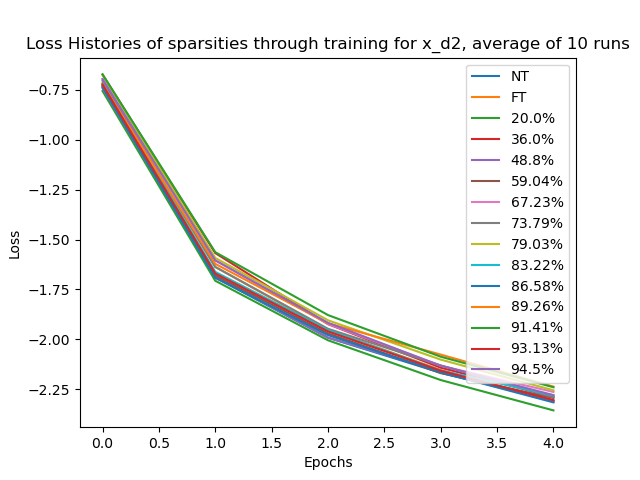

In [11]:
plt.figure(5)
# Plot each loss history with a different label
for i, loss_history in enumerate(calculate_average_loss(data_dict_unstructured["MI_hist_x_d2"])):
    plt.plot(-loss_history,label=custom_labels[i])

plt.legend()
# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Histories of sparsities through training for x_d2, average of {averaging_iterations} runs')


# Show the plot
plt.show()

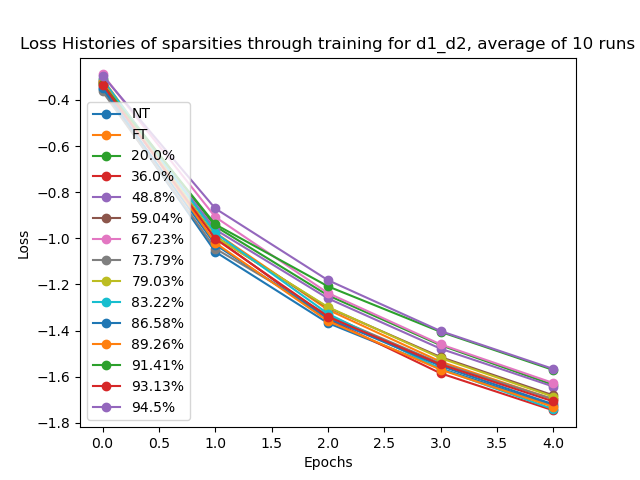

In [12]:
plt.figure(6)
# Plot each loss history with a different label
for i, loss_history in enumerate(calculate_average_loss(data_dict_unstructured["MI_hist_d1_d2"])):
    plt.plot(-loss_history, 'o-', label=custom_labels[i])

plt.legend()
# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Histories of sparsities through training for d1_d2, average of {averaging_iterations} runs')


# Show the plot
plt.show()